In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import simpy
from random import sample 
import datetime
from collections import defaultdict
import scipy.stats
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.policies import policy_saver
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import trajectory

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

Loading trip data...
Data loading complete


In [2]:
#register custom environment
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper parameters

num_iterations = 30 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

epsilon_greedy = 0.01 #should be low for imitation learning, higher for regular q learning

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()

In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy = epsilon_greedy)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)

In [6]:
#create dataset and iterator
#Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [7]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])

init
hex count  114
Number of trips generated: 1841


In [8]:
#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [9]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            print(int(np.array([state_list[i]["observation"]])[0][1]))
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", hrly_trip_counts )
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

5
[[19.4         5.         41.26063044 27.71320149 20.        ]]
5
[[41.7         5.          2.42136679  0.56463806 19.        ]]
8
[[28.7         8.         28.35732632 18.40049225 18.        ]]
12
[[ 7.1        12.          8.08338439 16.60331378 17.        ]]
12
[[ 7.5   12.    12.821 22.715 16.   ]]
12
[[28.2        12.         25.89507498 47.99210949 15.        ]]
12
[[14.2   12.    12.171 49.556 14.   ]]
12
[[20.9        12.         33.41621812 40.22206041 13.        ]]
17
[[43.5        17.         50.48462035 19.89653686 12.        ]]
8
[[ 6.1         8.         48.71586981 25.73821838 11.        ]]
12
[[26.2        12.         59.39503121  5.30476189 10.        ]]
driver reward  90.36000000000004
7
[[ 8.1         7.         20.78201043 45.07236933 20.        ]]
7
[[15.2         7.         24.06567644 52.46938624 19.        ]]
7
[[27.3         7.          6.54029964 26.0402683  18.        ]]
8
[[17.7         8.         11.80713814 51.92728676 17.        ]]
9
[[26.5         9. 

[[16.9        20.          0.75302447 36.81672029  3.        ]]
20
[[ 9.         20.         13.50233352 41.29719729  2.        ]]
20
[[15.5        20.         25.95583197 54.48220794  1.        ]]
22
[[24.7        22.         23.91732783 52.12682392 20.        ]]
6
[[11.3         6.         14.64083356 43.24203173 19.        ]]
7
[[ 5.5    7.     8.991 38.643 18.   ]]
7
[[ 6.9    7.     5.013 40.101 17.   ]]
7
[[29.2         7.         21.23207685 25.88564327 16.        ]]
7
[[29.          7.         35.35702913  0.30859696 15.        ]]
11
[[39.8   11.     5.85  50.673 14.   ]]
12
[[ 6.4   12.     4.428 60.    13.   ]]
12
[[12.5        12.         16.84624771 47.81129629 12.        ]]
12
[[ 7.    12.    11.652 46.53  11.   ]]
12
[[11.    12.     6.326 46.695 10.   ]]
12
[[12.9        12.         13.24423148 28.67097987  9.        ]]
12
[[27.9        12.         31.68592138 15.2914417   8.        ]]
13
[[19.3        13.         44.85986113 20.04244007  7.        ]]
16
[[17.8        16

[[19.8        16.         33.36235731 51.63399262 -1.        ]]
17
[[12.9        17.         26.14370673 58.82906894 -1.        ]]
17
[[13.3        17.         23.96462115 56.01239032 -1.        ]]
17
[[14.7        17.         21.24445483 37.4083179  -1.        ]]
17
[[14.2        17.         16.15372431 19.07376855 -1.        ]]
17
[[16.8        17.         13.92418544  5.97666987 -1.        ]]
17
[[45.4        17.         39.0483248  49.76201233 -1.        ]]
17
[[ 7.3        17.         38.5929668  42.43586364 -1.        ]]
18
[[13.8        18.         21.86847921 46.24174108 -1.        ]]
18
[[10.9        18.         15.25584886 21.40296546 -1.        ]]
18
[[46.7        18.         50.9965784   0.30807099 -1.        ]]
driver reward  29376.35999999999
7
[[ 9.4         7.         33.157095   58.96000487 20.        ]]
8
[[ 8.6    8.    14.899 55.096 19.   ]]
9
[[16.2         9.         26.55952476 35.53461258 18.        ]]
9
[[16.2         9.         24.68362926 52.68867597 17.     

[[16.6   15.    39.396 30.38   1.   ]]
15
[[22.5        15.         13.19323302 26.00031346 10.        ]]
15
[[ 2.    15.     2.105 44.538  9.   ]]
16
[[ 6.3        16.          3.85160853 47.92588472  8.        ]]
16
[[ 3.8   16.    11.978 48.8    7.   ]]
16
[[12.2   16.     6.5   27.186  6.   ]]
16
[[34.9        16.         28.48872572 47.28940149  5.        ]]
16
[[19.7        16.         11.19411059 30.83064783  4.        ]]
16
[[14.4        16.          5.2763615  23.92750309  3.        ]]
17
[[11.6        17.         11.40978614 19.28735863  2.        ]]
17
[[20.2        17.          7.09338206 51.88413387  1.        ]]
17
[[ 7.1        17.          1.5093634  56.41908245 20.        ]]
17
[[16.4        17.         10.18421166 30.6515992  19.        ]]
17
[[16.         17.         22.28391441 30.9931188  18.        ]]
18
[[30.         18.         36.59508675  6.65249385 17.        ]]
19
[[ 9.    19.    48.448 10.88  16.   ]]
10
[[13.8   10.    45.341 24.281 15.   ]]
14
[[25.8     

[[38.1   18.     9.179 38.79  12.   ]]
18
[[10.7        18.         16.20150799 22.78651289 11.        ]]
18
[[ 5.2        18.          7.83854363 23.86526109 10.        ]]
18
[[ 8.9        18.          1.98436441 28.41988064  9.        ]]
18
[[12.2        18.         14.35740435 30.58860799  8.        ]]
18
[[ 6.5   18.     8.424 26.287  7.   ]]
19
[[15.4        19.         17.2875732  32.53300301  6.        ]]
19
[[5.80000000e+00 1.90000000e+01 2.69621361e-02 5.26379019e+01
  5.00000000e+00]]
19
[[13.         19.         17.40291671 42.39746733  4.        ]]
19
[[ 4.4        19.         13.29762981 28.16168865  3.        ]]
19
[[ 6.1        19.          2.72705923 20.5192387   2.        ]]
19
[[20.6        19.         27.31962724 27.8535129   1.        ]]
22
[[19.8   22.     5.779 30.402 25.   ]]
driver reward  20919.039999999997
0
[[15.2         0.         14.00455014 36.24060509 20.        ]]
2
[[ 3.8         2.          6.85116525 26.86307524 19.        ]]
7
[[34.7         7.     

[[ 8.          2.          9.99779902  9.70149594 16.        ]]
5
[[20.6         5.         34.97338939 22.37712947 15.        ]]
7
[[30.          7.         59.35438461 41.74939202 14.        ]]
13
[[11.6        13.         55.5554767  40.21858248 13.        ]]
20
[[11.1        20.         48.96595155 46.36302359 12.        ]]
20
[[20.7   20.    24.834 36.716 11.   ]]
21
[[ 5.5   21.     1.085 37.73  10.   ]]
22
[[ 7.4        22.          2.25100841 51.7165001   9.        ]]
22
[[12.2        22.          9.29161834 35.99532996  8.        ]]
23
[[20.2   23.     7.038 14.462  7.   ]]
driver reward  13946.679999999993
19
[[15.7        19.         48.89410921 29.71737355 20.        ]]
9
[[40.3    9.     9.815 60.    19.   ]]
11
[[11.1        11.          9.67456099 42.39061568 18.        ]]
12
[[10.6   12.     3.926 46.456 17.   ]]
12
[[24.7        12.         33.8539509  54.69714263 16.        ]]
13
[[ 5.6        13.         36.19071806 56.08190759 15.        ]]
13
[[19.7        13.     

## Reinforcement Learning Q-Learning

In [10]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

## Imitation Learning

### load data

In [11]:
#imitation learning strategy
#parse pickme data into trajectories
#pickup distance ignored since it is nto available in dataset
#load data
import pandas as pd 
import math
from tqdm import tqdm

#driver_actions_table =  pd.read_csv("../data/driver-action.csv") 
trip_data =  pd.read_csv("../data/trip-data.csv") 

In [12]:
trip_data.head(10)

,passengerslogid,driverid,pickuplatitude,pickuplongitude,droplatitude,droplongitude,actualpickuptime,paymentmethod,isdirectionalhire,distance,travelstatus,taximodelid,createddate
0,212553104,188,6.03305,80.2168,6.07534,80.2346,NaN,1,NaN,NaN,11,1,2020-02-01 00:08:28.0
1,212554705,188,6.93233,79.8492,6.91947,79.9114,NaN,1,NaN,NaN,12,1,2020-02-01 00:25:27.0
2,212555287,0,6.93257,79.8486,6.82994,79.9101,NaN,1,NaN,NaN,11,1,2020-02-01 00:30:43.0
3,212557334,18930,6.90514,79.8788,6.89894,79.8771,2020-02-01 01:00:37.0,1,NaN,1.28,1,1,2020-02-01 00:53:54.0
4,212558261,117344,6.88920,79.8895,6.91505,79.9531,2020-02-01 01:11:07.0,1,NaN,9.78,1,1,2020-02-01 01:06:08.0
5,212560424,0,7.21436,79.8471,7.22546,79.8520,NaN,1,NaN,NaN,11,1,2020-02-01 01:52:20.0
6,212565638,0,6.88655,79.8583,6.92075,79.8561,NaN,2,NaN,NaN,11,1,2020-02-01 05:36:30.0
7,212565684,107426,6.84864,79.9635,6.85434,79.8923,2020-02-01 05:42:07.0,1,NaN,9.80,1,1,2020-02-01 05:37:34.0
8,212567228,16925,6.86133,79.8781,6.85090,79.8661,2020-02-01 06:22:50.0,1,NaN,2.28,1,1,2020-02-01 06:17:46.0
9,212571010,0,7.03675,79.9023,7.02326,79.9092,NaN,1,NaN,NaN,11,1,2020-02-01 07:19:46.0


In [259]:
"""driver_actions_table.head(10)"""

old_driver_actions_table =  pd.read_csv("../data/driver-action.csv")
old_driver_actions_table

,trip_id,created_driver_id,assigned_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type
0,212552700,0,38457.0,38457.0,38457.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
1,212552700,0,79308.0,79308.0,79308.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
2,212552700,0,60511.0,60511.0,60511.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
3,212552700,0,11251.0,11251.0,11251.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
4,212552700,0,22304.0,22304.0,22304.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732161,218778071,0,82477.0,82477.0,82477.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,SYSTEM_REJECTED
6732162,218778071,0,8193.0,8193.0,8193.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL
6732163,218778541,0,112821.0,112821.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,NaN
6732164,218778541,0,102857.0,102857.0,102857.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL


### data preprocessing

In [14]:
#drop duplicated rows
"""driver_actions_table.drop_duplicates(keep = 'first', inplace = True)"""

#drop rows with assigned driver null
"""driver_actions_table.drop(driver_actions_table[driver_actions_table['assigned_driver_id'].isnull()].index, inplace=True)"""

"driver_actions_table.drop(driver_actions_table[driver_actions_table['assigned_driver_id'].isnull()].index, inplace=True)"

In [15]:
#make a double index
"""driver_actions_table[['trip_id', 'assigned_driver_id']] = driver_actions_table[['trip_id', 'assigned_driver_id']].apply(pd.to_numeric).applymap(np.int64).astype(str)
driver_actions_table.set_index(['assigned_driver_id', 'trip_id'], inplace=True)
driver_actions_table.head()"""

"driver_actions_table[['trip_id', 'assigned_driver_id']] = driver_actions_table[['trip_id', 'assigned_driver_id']].apply(pd.to_numeric).applymap(np.int64).astype(str)\ndriver_actions_table.set_index(['assigned_driver_id', 'trip_id'], inplace=True)\ndriver_actions_table.head()"

In [16]:
#get the week number
"""driver_actions_table['created_date'] = pd.to_datetime(driver_actions_table['created_date'])

def getWeekNumber(x):
    if datetime.date(2020, 2, 3) <= x <= datetime.date(2020, 2, 9):
        return 1
    elif datetime.date(2020, 2, 10) <= x <= datetime.date(2020, 2, 16):
        return 2
    elif datetime.date(2020, 2, 17) <= x <= datetime.date(2020, 2, 23):
        return 3
    elif datetime.date(2020, 2, 24) <= x <= datetime.date(2020, 3, 1):
        return 4
    else:
        return 0

driver_actions_table['week_no'] = driver_actions_table['created_date'].apply(getWeekNumber)"""

"driver_actions_table['created_date'] = pd.to_datetime(driver_actions_table['created_date'])\n\ndef getWeekNumber(x):\n    if datetime.date(2020, 2, 3) <= x <= datetime.date(2020, 2, 9):\n        return 1\n    elif datetime.date(2020, 2, 10) <= x <= datetime.date(2020, 2, 16):\n        return 2\n    elif datetime.date(2020, 2, 17) <= x <= datetime.date(2020, 2, 23):\n        return 3\n    elif datetime.date(2020, 2, 24) <= x <= datetime.date(2020, 3, 1):\n        return 4\n    else:\n        return 0\n\ndriver_actions_table['week_no'] = driver_actions_table['created_date'].apply(getWeekNumber)"

In [17]:
#drop week number 0 trips
"""driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==0].index, inplace=True)"""

"driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==0].index, inplace=True)"

In [18]:
#count accepted trips within the week

"""def count_accepted_trips(df, week_num):
    trip_counts = defaultdict(int)
    for index, row in tqdm(df[(df['week_no']==week_num)].iterrows()):
        driver_id = index[0]
        df.at[index,'accepted_trip_count'] = trip_counts[driver_id]
        if not np.isnan(row['accepted_driver_id']):
          trip_counts[driver_id] += 1

driver_actions_table['accepted_trip_count'] = 0

for week in tqdm(range(1,5)):
    count_accepted_trips(driver_actions_table,week)"""

"def count_accepted_trips(df, week_num):\n    trip_counts = defaultdict(int)\n    for index, row in tqdm(df[(df['week_no']==week_num)].iterrows()):\n        driver_id = index[0]\n        df.at[index,'accepted_trip_count'] = trip_counts[driver_id]\n        if not np.isnan(row['accepted_driver_id']):\n          trip_counts[driver_id] += 1\n\ndriver_actions_table['accepted_trip_count'] = 0\n\nfor week in tqdm(range(1,5)):\n    count_accepted_trips(driver_actions_table,week)"

In [19]:
driver_actions_table = pd.read_csv("../data/driver_actions_weekly_trips.csv") 
driver_actions_table

,assigned_driver_id,trip_id,created_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type,week_no,accepted_trip_count
0,117849,212895149,0,117849.0,117849.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0
1,22119,212895149,0,22119.0,NaN,22119.0,NaN,NaN,NaN,NaN,1,2020-02-03,NaN,1,0
2,83939,212895973,0,83939.0,83939.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0
3,115428,212895973,0,115428.0,115428.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0
4,48557,212895973,0,48557.0,48557.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,MANUAL,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602767,82477,218778071,0,82477.0,82477.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,SYSTEM_REJECTED,4,41
5602768,8193,218778071,0,8193.0,8193.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,25
5602769,112821,218778541,0,112821.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,NaN,4,28
5602770,102857,218778541,0,102857.0,102857.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,9


In [20]:
#get trips till reward
def getTripsTillReward(x):
    if x < 20:
        return 20-x
    elif x < 30:
        return 30-x
    elif x < 50:
        return 50-x
    elif x < 75:
        return 75-x
    elif x < 100:
        return 100-x
    elif x < 125:
        return 125-x
    else:
        return 0

driver_actions_table['trips_till_reward'] = driver_actions_table['accepted_trip_count'].apply(getTripsTillReward)

In [21]:
driver_behaviours = []

#trajectory format - trip distance, time of day, drop location_long, drop_location_lat, (trips_till_weekly_reward)

#MANUAL and SYSTEM_REJECTED count as rejected, null counts as acccepted

bool_accepted_series = pd.notnull(driver_actions_table["accepted_driver_id"])  #if a trip was rejected after accepting, it is considered acceptance within the scope
accepted_driver_actions = driver_actions_table[bool_accepted_series]
bool_rejected_series = pd.isnull(driver_actions_table["accepted_driver_id"]) & pd.notnull(driver_actions_table["rejected_driver_id"]) #trip neither accepted nor rejected were removed
rejected_driver_actions = driver_actions_table[bool_rejected_series]
print("total", len(driver_actions_table.index))
print("accepted", len(accepted_driver_actions.index))
print("rejected", len(rejected_driver_actions.index))
print("trips", len(trip_data.index))

total 5602772
accepted 1863480
rejected 3351821
trips 4046020


In [22]:
#insert decision
driver_actions_table["accept"] = bool_accepted_series

In [23]:
driver_actions_table

,assigned_driver_id,trip_id,created_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type,week_no,accepted_trip_count,trips_till_reward,accept
0,117849,212895149,0,117849.0,117849.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0,20,False
1,22119,212895149,0,22119.0,NaN,22119.0,NaN,NaN,NaN,NaN,1,2020-02-03,NaN,1,0,20,True
2,83939,212895973,0,83939.0,83939.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0,20,False
3,115428,212895973,0,115428.0,115428.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0,20,False
4,48557,212895973,0,48557.0,48557.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,MANUAL,1,0,20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602767,82477,218778071,0,82477.0,82477.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,SYSTEM_REJECTED,4,41,9,False
5602768,8193,218778071,0,8193.0,8193.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,25,5,False
5602769,112821,218778541,0,112821.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,NaN,4,28,2,False
5602770,102857,218778541,0,102857.0,102857.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,9,11,False


In [24]:
# TODO distance scale
# for rides without distance, estimate distance based on l2 distance and scaling 
# factor calculated from ratio between l2 distance and real distance
scaling_factor = 1.3

#get l2 distance (assume that locations are close to equator)
def l2_dist(x1, x2, y1, y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))*111 #mult by 111 to turn cordinates to km

In [25]:
# lookup drop location, trip distance, time from trip_data
def get_trip_data(trips, trip_id):
    trip = trips.loc[trips['passengerslogid'] == trip_id]
    #if exactly one record is found
    if (len(trip.index)) ==1:
        #trip = trip["droplatitude"]
        for tr in trip.iterrows():
            lat  = tr[1]["pickuplatitude"]
            long  = tr[1]["pickuplongitude"]
            time  = pd.to_datetime(tr[1]["createddate"])
            
            #check if distance is available
            if (math.isnan(tr[1]["distance"])):
                distance = scaling_factor * l2_dist(tr[1]["pickuplatitude"],
                                                   tr[1]["droplatitude"],
                                                   tr[1]["pickuplongitude"],
                                                   tr[1]["droplongitude"])                
            else:

                distance  = tr[1]["distance"]
            return {
                "drop_lat": lat,
                "drop_long": long,
                "time": time,
                "trip_dist": distance
            }
    else:
        return None
    #print(trip)


get_trip_data(trip_data, 212554705)

{'drop_lat': 6.93233,
 'drop_long': 79.8492,
 'time': Timestamp('2020-02-01 00:25:27'),
 'trip_dist': 9.165287626627732}

In [84]:
#create dataset
#drop week number 0 trips
driver_actions_train = driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==4].index)

#sample trips randomly
driver_actions_train = driver_actions_train.sample(n=500000)

In [85]:
# group behaviour by drivers, sorted by time
#rejected_driver_actions['rejected_driver_id'].nunique()
#create dictionary with entry for each driver. the entry is a list of actions
driver_actions ={}

for id, row in tqdm(driver_actions_train.iterrows()):

    #print(row["trip_id"])
    observation = get_trip_data(trip_data, row["trip_id"])
    if observation is not None:
        observation.update({"trips_till_reward": int(row["trips_till_reward"])})
    else:
        continue
    action = {"accept": int(row["accept"]), "observation": observation}
    key = str(int(row["assigned_driver_id"]))

    #add to driver actions table
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)

"""#loop through accepted trips
for id, row in tqdm(accepted_driver_actions.iterrows()):
    count+=1
    if count == 10000: #temporary limit for testing
        break
        
    #print(row["trip_id"])
    action = {"accept": 1, "observation": get_trip_data(trip_data, row["trip_id"])}
    key = str(int(row["accepted_driver_id"]))

    #add to driver actions table
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
        
#loop through rejected trips
count = 0

for id, row in tqdm(rejected_driver_actions.iterrows()):
    count+=1
    if count == 10000:
        break
        
    #print(row["trip_id"])
    action = {"accept": 0, "observation": get_trip_data(trip_data, row["trip_id"])}
    if (math.isnan(row["rejected_driver_id"])):
        continue
    key = str(int(row["rejected_driver_id"]))
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
 
"""

500000it [1:16:16, 109.24it/s]


'#loop through accepted trips\nfor id, row in tqdm(accepted_driver_actions.iterrows()):\n    count+=1\n    if count == 10000: #temporary limit for testing\n        break\n        \n    #print(row["trip_id"])\n    action = {"accept": 1, "observation": get_trip_data(trip_data, row["trip_id"])}\n    key = str(int(row["accepted_driver_id"]))\n\n    #add to driver actions table\n    if key not in driver_actions:\n        driver_actions[key] = [action]\n    else:\n        driver_actions[key].append(action)\n        \n#loop through rejected trips\ncount = 0\n\nfor id, row in tqdm(rejected_driver_actions.iterrows()):\n    count+=1\n    if count == 10000:\n        break\n        \n    #print(row["trip_id"])\n    action = {"accept": 0, "observation": get_trip_data(trip_data, row["trip_id"])}\n    if (math.isnan(row["rejected_driver_id"])):\n        continue\n    key = str(int(row["rejected_driver_id"]))\n    if key not in driver_actions:\n        driver_actions[key] = [action]\n    else:\n      

In [86]:
#sort action in order (based on time)

#remove invalid values
for driver in driver_actions:
    refined_actions = []
    for action in driver_actions[driver]:
        try:
            time = action['observation']["time"].value
            refined_actions.append(action)
        except:
            continue
    driver_actions[driver] = refined_actions
    
for driver in driver_actions:
        driver_actions[driver] = sorted(driver_actions[driver], key = lambda i: i['observation']["time"].value)

#switch time to hour of day
for driver in driver_actions:
    for action in driver_actions[driver]:
        action["observation"]["time"] = action["observation"]["time"].hour

In [87]:
print(driver_actions["66075"])

[{'accept': 0, 'observation': {'drop_lat': 6.79373, 'drop_long': 79.9167, 'time': 15, 'trip_dist': 1.4499357059414373, 'trips_till_reward': 11}}, {'accept': 1, 'observation': {'drop_lat': 6.84507, 'drop_long': 79.93, 'time': 20, 'trip_dist': 0.63, 'trips_till_reward': 17}}, {'accept': 0, 'observation': {'drop_lat': 6.82777, 'drop_long': 79.8802, 'time': 23, 'trip_dist': 1.5403381212537572, 'trips_till_reward': 4}}, {'accept': 1, 'observation': {'drop_lat': 6.94349, 'drop_long': 79.8606, 'time': 3, 'trip_dist': 2.0394082923247234, 'trips_till_reward': 9}}, {'accept': 1, 'observation': {'drop_lat': 6.81496, 'drop_long': 79.8783, 'time': 22, 'trip_dist': 12.92, 'trips_till_reward': 18}}, {'accept': 1, 'observation': {'drop_lat': 6.85335, 'drop_long': 79.9206, 'time': 0, 'trip_dist': 3.25868763786813, 'trips_till_reward': 13}}, {'accept': 0, 'observation': {'drop_lat': 6.839, 'drop_long': 79.8647, 'time': 1, 'trip_dist': 6.205508211470385, 'trips_till_reward': 15}}, {'accept': 0, 'observat

### dataset preparation

In [88]:
# create trajectory collection from pickme trajectory set
#reward is set to 0 because it is  not available in the dataset and at this stage the agent does not explore

driver_trajectories = []

#loop through drivers
for key in driver_actions:
    #driver must have at least 2 rides to create a trajectory
    if len(driver_actions[key]) > 1:
        states = []
        actions = []

        #convert states directly to tf timesteps
        for i in range(len(driver_actions[key])):
            #create time step
            obs = driver_actions[key][i]["observation"]
            obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"], obs["trips_till_reward"]]
            if i == 0:
                #initial trajectory
                state_tf = ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            elif i < (len(driver_actions[key]) - 1):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))
            else:
                #terminating tranjectory
                state_tf = ts.TimeStep(tf.constant([2]), tf.constant([0.0]), tf.constant([0.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            #create action
            #action = state_list[i]["action"]
            action = policy_step.PolicyStep(tf.constant([driver_actions[key][i]["accept"]], dtype=tf.int64), ())
            #print (action)
            states.append(state_tf)
            actions.append(action)

        for j in range(len(states)-1):
            present_state = states[j]
            #print(present_state)
            next_state = states[j+1]
            action = actions[j]

            traj = trajectory.from_transition(present_state, action, next_state)
            #print(action)
            # Add trajectory to the replay buffer
            driver_trajectories.append(traj)
            #replay_buffer.add_batch(traj)
            #print(traj)

print(len(driver_trajectories))
#cache trajectories as json to disk?

#convert trajectories to tf agents format

486176


In [89]:
#add subset of trajectorise to replay buffer
def collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories):
    #sample from trajectories
    sample_trajectories = sample(driver_trajectories, num_trajectories)
    for traj in sample_trajectories:
        replay_buffer.add_batch(traj)

In [90]:
num_trajectories = 10000
#collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)

### model training - WIP

In [91]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()

In [261]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        
        #imitation learning
        collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)
        
        #regular q learning
        #collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()
        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))
        
        #evaluation
        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policdriver_trajectoriesy_%d' % step)
        
        
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114
Number of trips generated: 1855
hex count  114
Number of trips generated: 1911
tf.Tensor(316567.47, shape=(), dtype=float32)
 Average Return = 316567.46875
hex count  114
Number of trips generated: 1876
hex count  114
Number of trips generated: 2023
tf.Tensor(302480.7, shape=(), dtype=float32)
step = 5: Average Return = 302480.6875
evaluation
step = 10: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=14.6998825>, extra=DqnLossInfo(td_loss=<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([6.18318415e+00, 8.56159115e+00, 7.00262308e-01, 1.49305277e+01,
       1.67876947e+00, 4.40216839e-01, 2.97289791e+01, 3.78162909e+00,
       5.37217283e+00, 1.58904467e+01, 4.24942255e+00, 8.23786974e-01,
       2.03328937e-01, 5.26089001e+00, 5.46484070e+02, 1.54102907e+01,
       3.21758777e-01, 2.61894250e+00, 4.09203023e-02, 1.78389606e+01,
       6.24970436e+00, 3.71270442e+00, 4.65402126e+00, 3.03202152e+00,
       8.07148814e-01, 7.70061207e+00, 9.60387886e-01

Number of trips generated: 2086
hex count  114
Number of trips generated: 2044
tf.Tensor(333630.78, shape=(), dtype=float32)
step = 30: Average Return = 333630.78125
evaluation


Text(0.5, 0, 'Iterations')

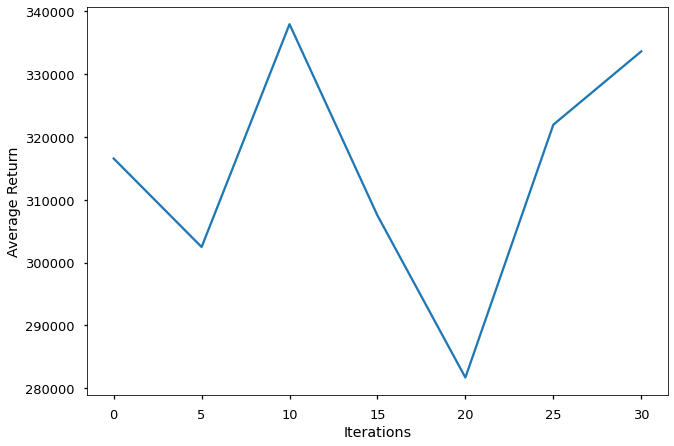

In [262]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

# Evaluation

## Evaluation Against Real Data

In [263]:
driver_actions_test_sample = driver_actions_table[driver_actions_table['week_no']==4]

In [264]:
#sample trips randomly
driver_actions_test_sample = driver_actions_test_sample.sample(n=25000)

In [265]:
# group behaviour by drivers, sorted by time
#rejected_driver_actions['rejected_driver_id'].nunique()
#create dictionary with entry for each driver. the entry is a list of actions
driver_actions_test ={}

for id, row in tqdm(driver_actions_test_sample.iterrows()):

    #print(row["trip_id"])
    observation = get_trip_data(trip_data, row["trip_id"])
    if observation is not None:
        observation.update({"trips_till_reward": int(row["trips_till_reward"])})
    else:
        continue
    action = {"accept": int(row["accept"]), "observation": observation}
    key = str(int(row["assigned_driver_id"]))

    #add to driver actions table
    if key not in driver_actions_test:
        driver_actions_test[key] = [action]
    else:
        driver_actions_test[key].append(action)

25000it [02:06, 198.24it/s]


In [266]:
#remove invalid values
for driver in driver_actions_test:
    refined_actions_test = []
    for action in driver_actions_test[driver]:
        try:
            time = action['observation']["time"].value
            refined_actions_test.append(action)
        except:
            continue
    driver_actions_test[driver] = refined_actions_test
    
for driver in driver_actions_test:
        driver_actions_test[driver] = sorted(driver_actions_test[driver], key = lambda i: i['observation']["time"].value)

#switch time to hour of day
for driver in driver_actions_test:
    for action in driver_actions_test[driver]:
        action["observation"]["time"] = action["observation"]["time"].hour

### Trip Distance

In [267]:
#get acceptance rates
episode_reward = 0
policy = eval_policy
trip_distance_brackets = [1, 2, 3, 4, 6, 10, 20]

trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
trip_trip_counts = np.zeros(len(trip_distance_brackets)+1)

real_accepted_trips = np.zeros(len(trip_distance_brackets)+1)

for key in driver_actions_test:
    for i in range(len(driver_actions_test[key])):
        obs = driver_actions_test[key][i]["observation"]
        obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"], obs["trips_till_reward"]]
        state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

        real_action = driver_actions_test[key][i]["accept"]
        agent_action = policy.action(state_tf)

        if (agent_action[0].numpy() == 1):
            trip_accepted_trips[sortDistance(obs["trip_dist"], trip_distance_brackets)] +=1
        if (real_action == 1):
            real_accepted_trips[sortDistance(obs["trip_dist"], trip_distance_brackets)] +=1
        trip_trip_counts[sortDistance(obs["trip_dist"], trip_distance_brackets)] +=1

In [268]:
#find average acceptance for trip distance
trip_acceptance_rates = []
real_acceptance_rates = []

print("trips", trip_trip_counts )
for j in range(len(trip_distance_brackets)+1):
    trip_acceptance_rates.append(float(trip_accepted_trips[j])/float(trip_trip_counts[j]))
    real_acceptance_rates.append(float(real_accepted_trips[j])/float(trip_trip_counts[j]))
    
print(trip_accepted_trips)
print(trip_acceptance_rates)
print(real_acceptance_rates)

trips [1385. 2675. 2996. 2779. 4247. 4563. 3169. 3183.]
[ 623. 1080. 1225. 1031. 1589. 1520.  736. 1854.]
[0.44981949458483755, 0.40373831775700936, 0.4088785046728972, 0.370996761424973, 0.37414645632210974, 0.33311417926802545, 0.23224992111076048, 0.5824693685202639]
[0.340072202166065, 0.30616822429906543, 0.30941255006675566, 0.29758906081324216, 0.31928420061219687, 0.3370589524435678, 0.3546860208267592, 0.27992459943449577]


In [269]:
trip_disti_labels = np.array(trip_distance_brackets)
agent_mean = np.array(trip_acceptance_rates)
real_mean = np.array(real_acceptance_rates)

In [270]:
distance_rates.append(trip_acceptance_rates)
real_distance_rates.append(real_trip_acceptance_rates)

NameError: name 'real_trip_acceptance_rates' is not defined

In [ ]:
generate_graph(np.arange(8), agent_mean, agent_mean, agent_mean, real_mean, real_mean, real_mean)


### Hours

In [ ]:
#get acceptance rates
episode_reward = 0
policy = eval_policy
hour_brackets = np.arange(24)[1:]

trip_accepted_trips = np.zeros(len(hour_brackets)+1)
trip_trip_counts = np.zeros(len(hour_brackets)+1)

real_accepted_trips = np.zeros(len(hour_brackets)+1)

for key in driver_actions_test:
    for i in range(len(driver_actions_test[key])):
        obs = driver_actions_test[key][i]["observation"]
        obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"], obs["trips_till_reward"]]
        state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

        real_action = driver_actions_test[key][i]["accept"]
        agent_action = policy.action(state_tf)

        if (agent_action[0].numpy() == 1):
            trip_accepted_trips[sortDistance(obs["trip_dist"], hour_brackets)] +=1
        if (real_action == 1):
            real_accepted_trips[sortDistance(obs["trip_dist"], hour_brackets)] +=1
        trip_trip_counts[sortDistance(obs["trip_dist"], hour_brackets)] +=1

In [ ]:
len(trip_accepted_trips)

In [ ]:
#find average acceptance for trip distance
trip_acceptance_rates = []
real_acceptance_rates = []

print("trips", trip_trip_counts )
for j in range(len(hour_brackets)+1):
    trip_acceptance_rates.append(float(trip_accepted_trips[j])/float(trip_trip_counts[j]))
    real_acceptance_rates.append(float(real_accepted_trips[j])/float(trip_trip_counts[j]))
    
print(trip_accepted_trips)
print(trip_acceptance_rates)
print(real_acceptance_rates)

In [ ]:
trip_disti_labels = np.array(trip_distance_brackets)
agent_mean = np.array(trip_acceptance_rates)
real_mean = np.array(real_acceptance_rates)

In [ ]:
hourly_rates.append(trip_acceptance_rates)
real_hourly_rates.append(real_acceptance_rates)

In [ ]:
generate_graph(np.arange(25)[1:], agent_mean, agent_mean, agent_mean, real_mean, real_mean, real_mean)


In [ ]:
len(np.arange(25)[1:])

In [ ]:
""""with open('../listfile.txt', 'w') as filehandle:
    filehandle.write(str(str(distance_rates) + "\n" + str(real_distance_rates) + "\n" + str(hourly_rates) + "\n" + str(real_hourly_rates)))""""

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [ ]:
def getCIs(rates, brackets):
    CIs = []
    for i in range (len(brackets)+1):
        vals = [x[i] for x in rates]
        CI = mean_confidence_interval(vals)
        CIs.append(CI)
    return np.array(CIs)

In [ ]:
distance_rates_CIs = getCIs(distance_rates,trip_distance_brackets)
real_distance_rates_CIs = getCIs(real_distance_rates,trip_distance_brackets)

In [ ]:
hourly_rates_CIs = getCIs(hourly_rates,np.arange(23))
real_hourly_rates_CIs = getCIs(real_hourly_rates,np.arange(23))

In [ ]:
distance_rates_CIs

In [ ]:
real_distance_rates_CIs

In [ ]:
distance_rates_mean = distance_rates_CIs[:,0]
distance_rates_upper_ci = distance_rates_CIs[:,2]
distance_rates_lower_ci = distance_rates_CIs[:,1]

real_distance_rates_mean = real_distance_rates_CIs[:,0]
real_distance_rates_upper_ci = real_distance_rates_CIs[:,2]
real_distance_rates_lower_ci = real_distance_rates_CIs[:,1]

In [ ]:
hourly_rates_mean = hourly_rates_CIs[:,0]
hourly_rates_upper_ci = hourly_rates_CIs[:,2]
hourly_rates_lower_ci = hourly_rates_CIs[:,1]

real_hourly_rates_mean = real_hourly_rates_CIs[:,0]
real_hourly_rates_upper_ci = real_hourly_rates_CIs[:,2]
real_hourly_rates_lower_ci = real_hourly_rates_CIs[:,1]

In [ ]:
generate_graph(np.arange(25)[1:], hourly_rates_mean, hourly_rates_upper_ci, hourly_rates_lower_ci, real_hourly_rates_mean, real_hourly_rates_upper_ci, real_hourly_rates_lower_ci)



In [ ]:
generate_graph(np.arange(8), distance_rates_mean, distance_rates_upper_ci, distance_rates_lower_ci, real_distance_rates_mean, real_distance_rates_upper_ci, real_distance_rates_lower_ci)



In [83]:
"""from tf_agents.policies import policy_saver
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)

saver.save('WORKING POLICY')"""

In [260]:
distance_rates = []
real_distance_rates = []
hourly_rates = []
real_hourly_rates = []

## Evaluation against Simulation

In [57]:
#multiple eval envs for recording variation
eval_iterations = 5 # determines the CI
eval_envs = []
for i in range (eval_iterations):
    eval_envs.append(run_simulation([eval_policy]))

hex count  114
Number of trips generated: 2079
hex count  114
Number of trips generated: 2009
hex count  114
Number of trips generated: 1911
hex count  114
Number of trips generated: 2079
hex count  114
Number of trips generated: 2079


In [58]:
#categorize distance
def sortDistance(dist, distance_brackets):
    if dist > distance_brackets[-1]:
        return len(distance_brackets)
    for i in range(len(distance_brackets)):
        if dist <= distance_brackets[i]:
            return i

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [59]:
#evaluate a trained policy with respect to a pre-generated static environment

#calculate acceptance rates based on distances
def evaluatePolicyDistances(policy, eval_envs, iterations, trip_distance_brackets):
    rates = []
    
    for i in range(iterations):
        episode_reward = 0

        trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
        trip_trip_counts = np.zeros(len(trip_distance_brackets)+1)
        trip_acceptance_rates = []

        for state_list in eval_envs[i][0]:
            states = []
            driver_reward = 0

            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                action = policy.action(state_tf)
                #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
                if (action[0].numpy() == 1):
                    reward = state_list[i]["reward"]
                    #print(np.array([state_list[i]["observation"]]))
                    trip_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1
                else:
                    reward = 0
                #print (reward)
                driver_reward += reward
                trip_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1


            episode_reward += driver_reward
            print("driver reward ", driver_reward)
        print("total reward ", episode_reward)

        #find average acceptance for each hour
        print("trips", trip_trip_counts )
        for j in range(len(trip_distance_brackets)+1):
            trip_acceptance_rates.append(float(trip_accepted_trips[j])/float(trip_trip_counts[j]))
        print (trip_accepted_trips)
        print(trip_acceptance_rates)
        rates.append(trip_acceptance_rates)
        
    CIs = []
    means = []
    for i in range (len(trip_distance_brackets)+1):
        vals = [x[i] for x in rates]
        means.append(sum(vals)/len(vals))
        CIs.append(mean_confidence_interval(vals))
        
    print("means ", means, "CIs ", CIs)
    return np.array(means), np.array(CIs)

In [60]:
#trip distance evaluation
trip_dist_brackets = [1, 2, 3, 4, 6, 10, 20]
dist_means, dist_ci = evaluatePolicyDistances(eval_policy, eval_envs, eval_iterations, trip_dist_brackets)

driver reward  14554.000000000002
driver reward  70.95999999999998
driver reward  157.40000000000012
driver reward  3941.7200000000003
driver reward  14550.560000000005
driver reward  8770.039999999997
driver reward  22005.48
driver reward  8952.680000000004
driver reward  22004.679999999997
driver reward  21864.919999999995
driver reward  31827.08
driver reward  4351.48
driver reward  30899.44
driver reward  31214.68
driver reward  30973.12
driver reward  8592.84
driver reward  29840.96000000003
driver reward  22243.400000000016
driver reward  31603.88
driver reward  29665.119999999988
total reward  368084.44000000006
trips [ 12.  26.  37.  42. 137. 308. 714. 747.]
[ 12.  26.  37.  42. 137. 307. 713. 683.]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9967532467532467, 0.9985994397759104, 0.9143239625167336]
driver reward  3935.4400000000005
driver reward  4335.600000000002
driver reward  8533.56
driver reward  8715.480000000001
driver reward  9121.68
driver reward  14639.520000000002
driver reward  87

In [61]:
hour_brackets = np.arange(24)[1:]
hours_means, hours_ci = evaluatePolicyDistances(eval_policy, eval_envs, eval_iterations, hour_brackets)

driver reward  14554.000000000002
driver reward  70.95999999999998
driver reward  157.40000000000012
driver reward  3941.7200000000003
driver reward  14550.560000000005
driver reward  8770.039999999997
driver reward  22005.48
driver reward  8952.680000000004
driver reward  22004.679999999997
driver reward  21864.919999999995
driver reward  31827.08
driver reward  4351.48
driver reward  30899.44
driver reward  31214.68
driver reward  30973.12
driver reward  8592.84
driver reward  29840.96000000003
driver reward  22243.400000000016
driver reward  31603.88
driver reward  29665.119999999988
total reward  368084.44000000006
trips [ 12.  26.  37.  42.  68.  69.  81.  78.  82.  67.  76.  79.  71.  78.
  62.  79.  68.  66.  68.  67.  57.  43.  58. 589.]
[ 12.  26.  37.  42.  68.  69.  81.  78.  81.  67.  76.  79.  71.  78.
  62.  79.  68.  66.  68.  66.  57.  43.  53. 530.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9878048780487805, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98507462

# Graphs

In [62]:
def generate_graph(x_ticks:np.ndarray, mean:np.ndarray, upper_ci:np.ndarray, lower_ci:np.ndarray, mean2:np.ndarray, upper_ci2:np.ndarray, lower_ci2:np.ndarray):
    plt.style.use('seaborn-talk')
    fig, ax = plt.subplots()
#     ax.grid(False)
    xnew = np.linspace(x_ticks.min(), x_ticks.max(), 300)  
#     spl = make_interp_spline(x_ticks, real_data, k=3)
#     smooth_real = spl(xnew)   
#     ax.plot(xnew, smooth_real, color='r', zorder=20,label='Real Data')
    
    spl = make_interp_spline(x_ticks, mean, k=3)
    smooth_mean = spl(xnew)
    ax.plot(xnew, smooth_mean, color='b', zorder=20,label='Imitation Agent')
    
    spl = make_interp_spline(x_ticks, upper_ci, k=3)
    smooth_upper_ci = spl(xnew)
    
    spl = make_interp_spline(x_ticks, lower_ci, k=3)
    smooth_lower_ci = spl(xnew)
    
    ax.fill_between(xnew, smooth_lower_ci, smooth_upper_ci, color='b', alpha=.2, zorder=10)
    
    
    spl = make_interp_spline(x_ticks, mean2, k=3)
    smooth_mean2 = spl(xnew)
    ax.plot(xnew, smooth_mean2, color='r', zorder=20,label='Real Data')
    
    spl = make_interp_spline(x_ticks, upper_ci2, k=3)
    smooth_upper_ci2 = spl(xnew)
    
    spl = make_interp_spline(x_ticks, lower_ci2, k=3)
    smooth_lower_ci2 = spl(xnew)
    
    ax.fill_between(xnew, smooth_lower_ci2, smooth_upper_ci2, color='r', alpha=.2, zorder=10)
    
    
    ax.xaxis.set_ticks(x_ticks)
    ax.set_xlabel("Hour")
    ax.set_ylabel("Acceptance Rate")
    ax.legend()
    legend = ax.legend(frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    ax.set_title('Acceptance rate against time')

In [63]:
hr_mean = hours_ci[:,0]
hr_upper_ci = hours_ci[:,2]
hr_lower_ci = hours_ci[:,1]

In [64]:
acceptance_rate = np.array([0.4333273,  0.41107997, 0.42295269, 0.35349929, 0.37578457, 0.41188466,
 0.30923655, 0.25588599, 0.3515282,  0.60111521, 0.57970518, 0.48322666,
 0.5001554,  0.39433481, 0.4171559,  0.43428874, 0.37495712, 0.35778051,
 0.27528687, 0.28131443, 0.4753151,  0.45765417, 0.48390042, 0.45387896])

In [65]:
hr_mean.shape

(24,)

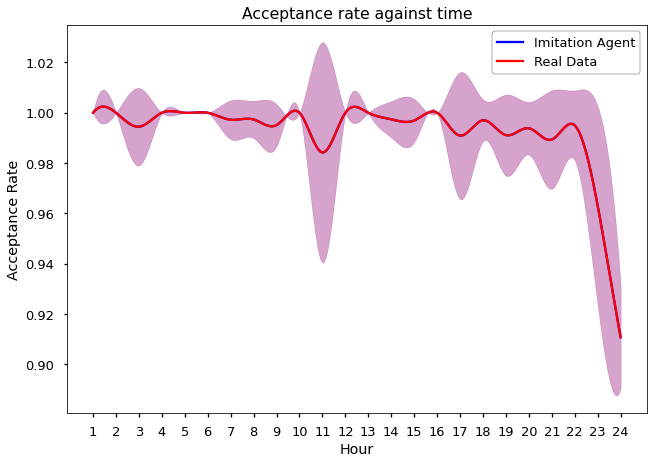

In [66]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, hr_mean, hr_upper_ci, hr_lower_ci)

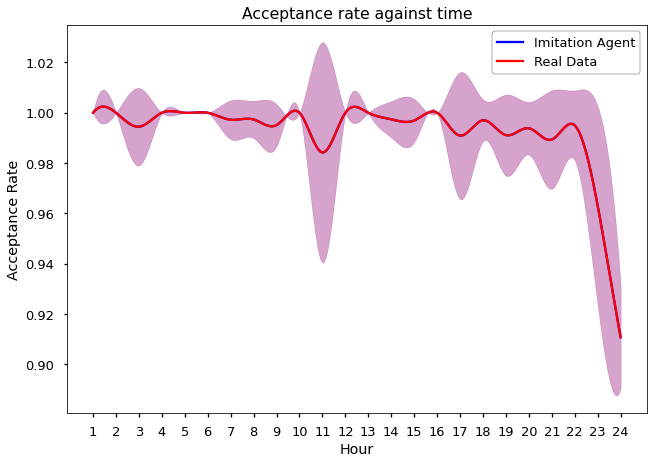

In [67]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, hr_mean, hr_upper_ci, hr_lower_ci)

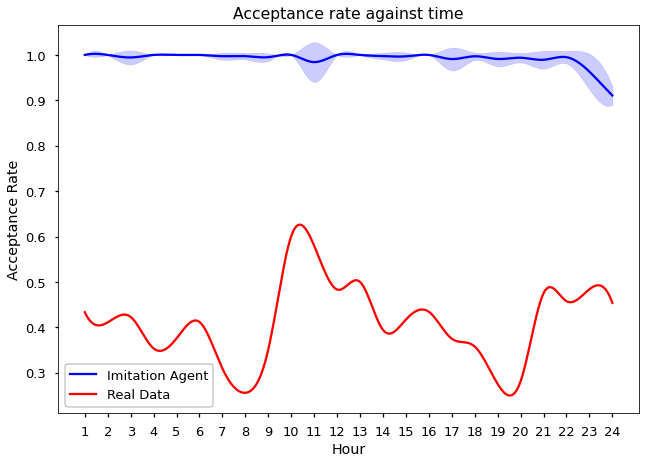

In [68]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, acceptance_rate, acceptance_rate, acceptance_rate)

In [169]:
dist_ci

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.75939850e-05, -4.74495174e-05,  1.22637487e-04],
       [ 2.20673876e-03,  1.74735604e-03,  2.66612147e-03]])

In [ ]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, hr_mean, hr_upper_ci, hr_lower_ci)

### end of imitation evaluation

In [17]:
#calculate acceptance rates based on distances
trip_distance_brackets = [1, 2, 3, 4, 6, 10]

def evaluatePolicyDistances(policy, eval_env):
    episode_reward = 0
    
    trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
    trip_trip_counts = np.zeros(len(trip_distance_brackets)+1)
    trip_acceptance_rates = []
    
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                #print(np.array([state_list[i]["observation"]]))
                trip_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            trip_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", trip_trip_counts )
    for j in range(len(trip_distance_brackets)+1):
        trip_acceptance_rates.append(float(trip_accepted_trips[j])/float(trip_trip_counts[j]))
    print (trip_accepted_trips)
    print(trip_acceptance_rates)
evaluatePolicyDistances(acceptPol, eval_env)

driver reward  1558.1200000000001
driver reward  9316.52
driver reward  21808.200000000004
driver reward  -414.9999999999999
driver reward  8780.519999999997
driver reward  8604.880000000001
driver reward  14551.679999999998
driver reward  4493.679999999999
driver reward  9619.560000000001
driver reward  21119.36
driver reward  29535.159999999996
driver reward  14079.319999999998
driver reward  21547.840000000007
driver reward  20287.080000000005
driver reward  28625.839999999982
driver reward  8872.919999999998
driver reward  29843.320000000007
driver reward  21488.92
driver reward  8830.799999999997
driver reward  21167.999999999993
total reward  303716.72
trips [  11.   25.   36.   41.  134.  290. 1342.]
[  11.   25.   36.   41.  134.  290. 1342.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [18]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

6
7
7
13
13
13
14
15
15
15
[[ 4.7        15.         11.94399489 43.5676033  11.        ]]
15
16
[[ 5.         16.         20.28484351 38.62650171  9.        ]]
16
[[ 7.4   16.    15.219 46.735  8.   ]]
16
18
18
18
18
19
19
[[ 5.8        19.          8.67131589 30.44341207  1.        ]]
19
19
7
7
8
driver reward  1340.72
15
16
16
16
18
19
20
20
2
7
8
8
9
9
10
17
17
17
[[ 7.1   17.    20.802 18.891  3.   ]]
17
17
[[ 2.2        17.          6.57772098 16.62656985  1.        ]]
17
17
17
7
7
7
7
7
7
8
10
13
13
14
14
14
15
16
16
16
16
16
17
17
17
17
17
[[ 3.4        17.          8.59109811 37.4642072   4.        ]]
17
16
16
16
16
17
18
18
19
[[ 8.7        19.          8.04658931 32.92016306 20.        ]]
19
19
19
[[ 4.4   19.    18.302 56.508 17.   ]]
19
driver reward  1171.16
7
7
8
9
9
9
9
9
9
9
10
10
10
10
10
12
[[ 2.8        12.         11.90756704 14.07198779  5.        ]]
15
[[ 6.2   15.    19.043 25.021  4.   ]]
16
16
16
17
17
17
20
20
[[ 3.4        20.         33.03474589 14.79318311

11
12
12
12
[[ 0.9   12.    12.379 25.73  25.   ]]
12
12
14
[[ 6.5        14.         29.4739473   9.63373854 22.        ]]
15
[[ 2.4        15.         13.83601071 28.88905693 21.        ]]
15
16
17
17
17
17
18
19
20
6
7
7
7
7
7
7
7
7
7
8
8
8
8
9
9
9
9
9
12
12
[[ 3.2        12.          7.62357061  3.53373487 16.        ]]
12
13
13
13
14
14
14
15
16
17
[[ 3.4        17.          4.18026286  3.46670333  6.        ]]
18
18
20
20
20
[[ 4.1        20.         18.99543481 26.96622712  1.        ]]
20
[[ 6.6   20.     9.608 23.731 25.   ]]
20
[[ 7.8        20.          6.69357913 20.96082863 24.        ]]
20
6
7
9
15
15
15
16
16
[[ 2.1        16.         30.88564102 38.06292443 15.        ]]
18
18
18
21
21
[[ 5.1        21.          0.42216787 32.72228292 10.        ]]
21
[[ 4.5   21.     9.497 18.925  9.   ]]
22
22
driver reward  6426.76
17
17
17
18
18
[[ 6.9        18.          8.36980166 37.5316888  16.        ]]
18
21
5
6
7
7
7
7
8
[[ 2.5         8.          7.50567501 35.62959368  7.  

/Users/tarindujayatilaka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
